<a href="https://colab.research.google.com/github/Anandalle2/Bharat_intern/blob/main/notebooks/train-yolov7-object-detection-on-custom-data-openvino-torch-ort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Run Inference on YOLOv7 with Native Pytorch and OpenVINO™ Torch-ORT

This tutorial is based on the [YOLOv7 repository](https://github.com/WongKinYiu/yolov7) by WongKinYiu. This notebook shows evaluation on **your own custom objects**. Many thanks to WongKinYiu and AlexeyAB for putting this repository together.

### **Accompanying Blog Post**

We recommend that you follow along in this notebook while reading the blog post: [Accelerate PyTorch Models via OpenVINO™ Integration with Torch-ORT](https://blog.roboflow.com/accelerate-pytorch-openvino-torch-ort/)
<br>



### **Custom Dataset**

Follow [the getting started guide here](https://docs.roboflow.com/quick-start) to create and prepare your own custom dataset.


If you already have your own images (and, optionally, annotations), you can convert your dataset using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 100k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv7), training, deploying, and improving their datasets/models.


### **Steps Covered in this Tutorial**

To run the inference on a test image we take the following steps:

* Evaluate YOLOv7 performance with Native Pytorch
* Evaluate YOLOv7 performance with OpenVINO™ integration with Torch-ORT

OPTIONAL:
* Reparameterize for Inference
* Deployment
* Active Learning

#Install Dependencies

_(Remember to choose None in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> None)_

Reminder, uploaded files will get deleted when this runtime is recycled.

In [1]:
# Download YOLOv7 repository from Roboflow-ai and install requirements
!git clone https://github.com/roboflow-ai/yolov7.git
%cd yolov7
!pip install -r requirements.txt

Cloning into 'yolov7'...
remote: Enumerating objects: 630, done.
remote: Total 630 (delta 0), reused 0 (delta 0), pack-reused 630 (from 1)
Receiving objects: 100% (630/630), 107.38 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (118/118), done.
/content/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 

In [2]:
!pip install torch==1.12.1

ERROR: Could not find a version that satisfies the requirement torch==1.12.1 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.12.1


# Download Correctly Formatted Custom Data

Next, we'll download our dataset in the right format. Use the `YOLOv7 PyTorch` export. Note that this model requires YOLO TXT annotations, a custom YAML file, and organized directories. The roboflow export writes this for us and saves it in the correct spot.

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7V4JO5rw8XDPaod54Qdc")
project = rf.workspace("a-s").project("uwh")
dataset = project.version(6).download("yolov7")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to UWH-6 in yolov7pytorch:: 100%|██████████| 1874/1874 [00:01<00:00, 1145.79it/s]


# Bring your own retrained model

If you have [retrained your yolov7 model on a custom dataset](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/) from the Roboflow Universe, follow the steps in this section.


**Note:** If you do not have retrained model, you can skip this section and use the pretrained model from ***content/yolov7/runs/best.pt***

In [4]:
# Mount your google drive to access the pretrained model obtained from https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

# Evaluate YOLOv7 performance with Native Pytorch

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

There are 2 minor changes we've made to run "detect.py" on CPU:
1.  We have commented out lines 38 and 39 in detect.py as the code is using [jit trace](https://pytorch.org/docs/stable/generated/torch.jit.trace.html).
2. Added lines 84 and 85 to enable device type as "cpu"

In [5]:
# If you DO NOT have a retrained model, use this command to run evaluation with the provided trained model:

!python detect_without_jit.py --weights /content/yolov7/runs/best.pt --conf 0.25 --img-size 640 --source UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg


Namespace(weights=['/content/yolov7/runs/best.pt'], source='UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 3cf1e25 torch 2.5.1+cu124 CPU

/content/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no l

Refer to "Display Inference on test image" section to display the saved image.

In [6]:
# Run evaluation on a sample image with a retrained model

!python detect_without_jit.py --weights /content/gdrive/MyDrive/TrainedModel/best.pt --conf 0.25 --img-size 640 --source UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg


Namespace(weights=['/content/gdrive/MyDrive/TrainedModel/best.pt'], source='UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 3cf1e25 torch 2.5.1+cu124 CPU

/content/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary o

# Display inference on test image

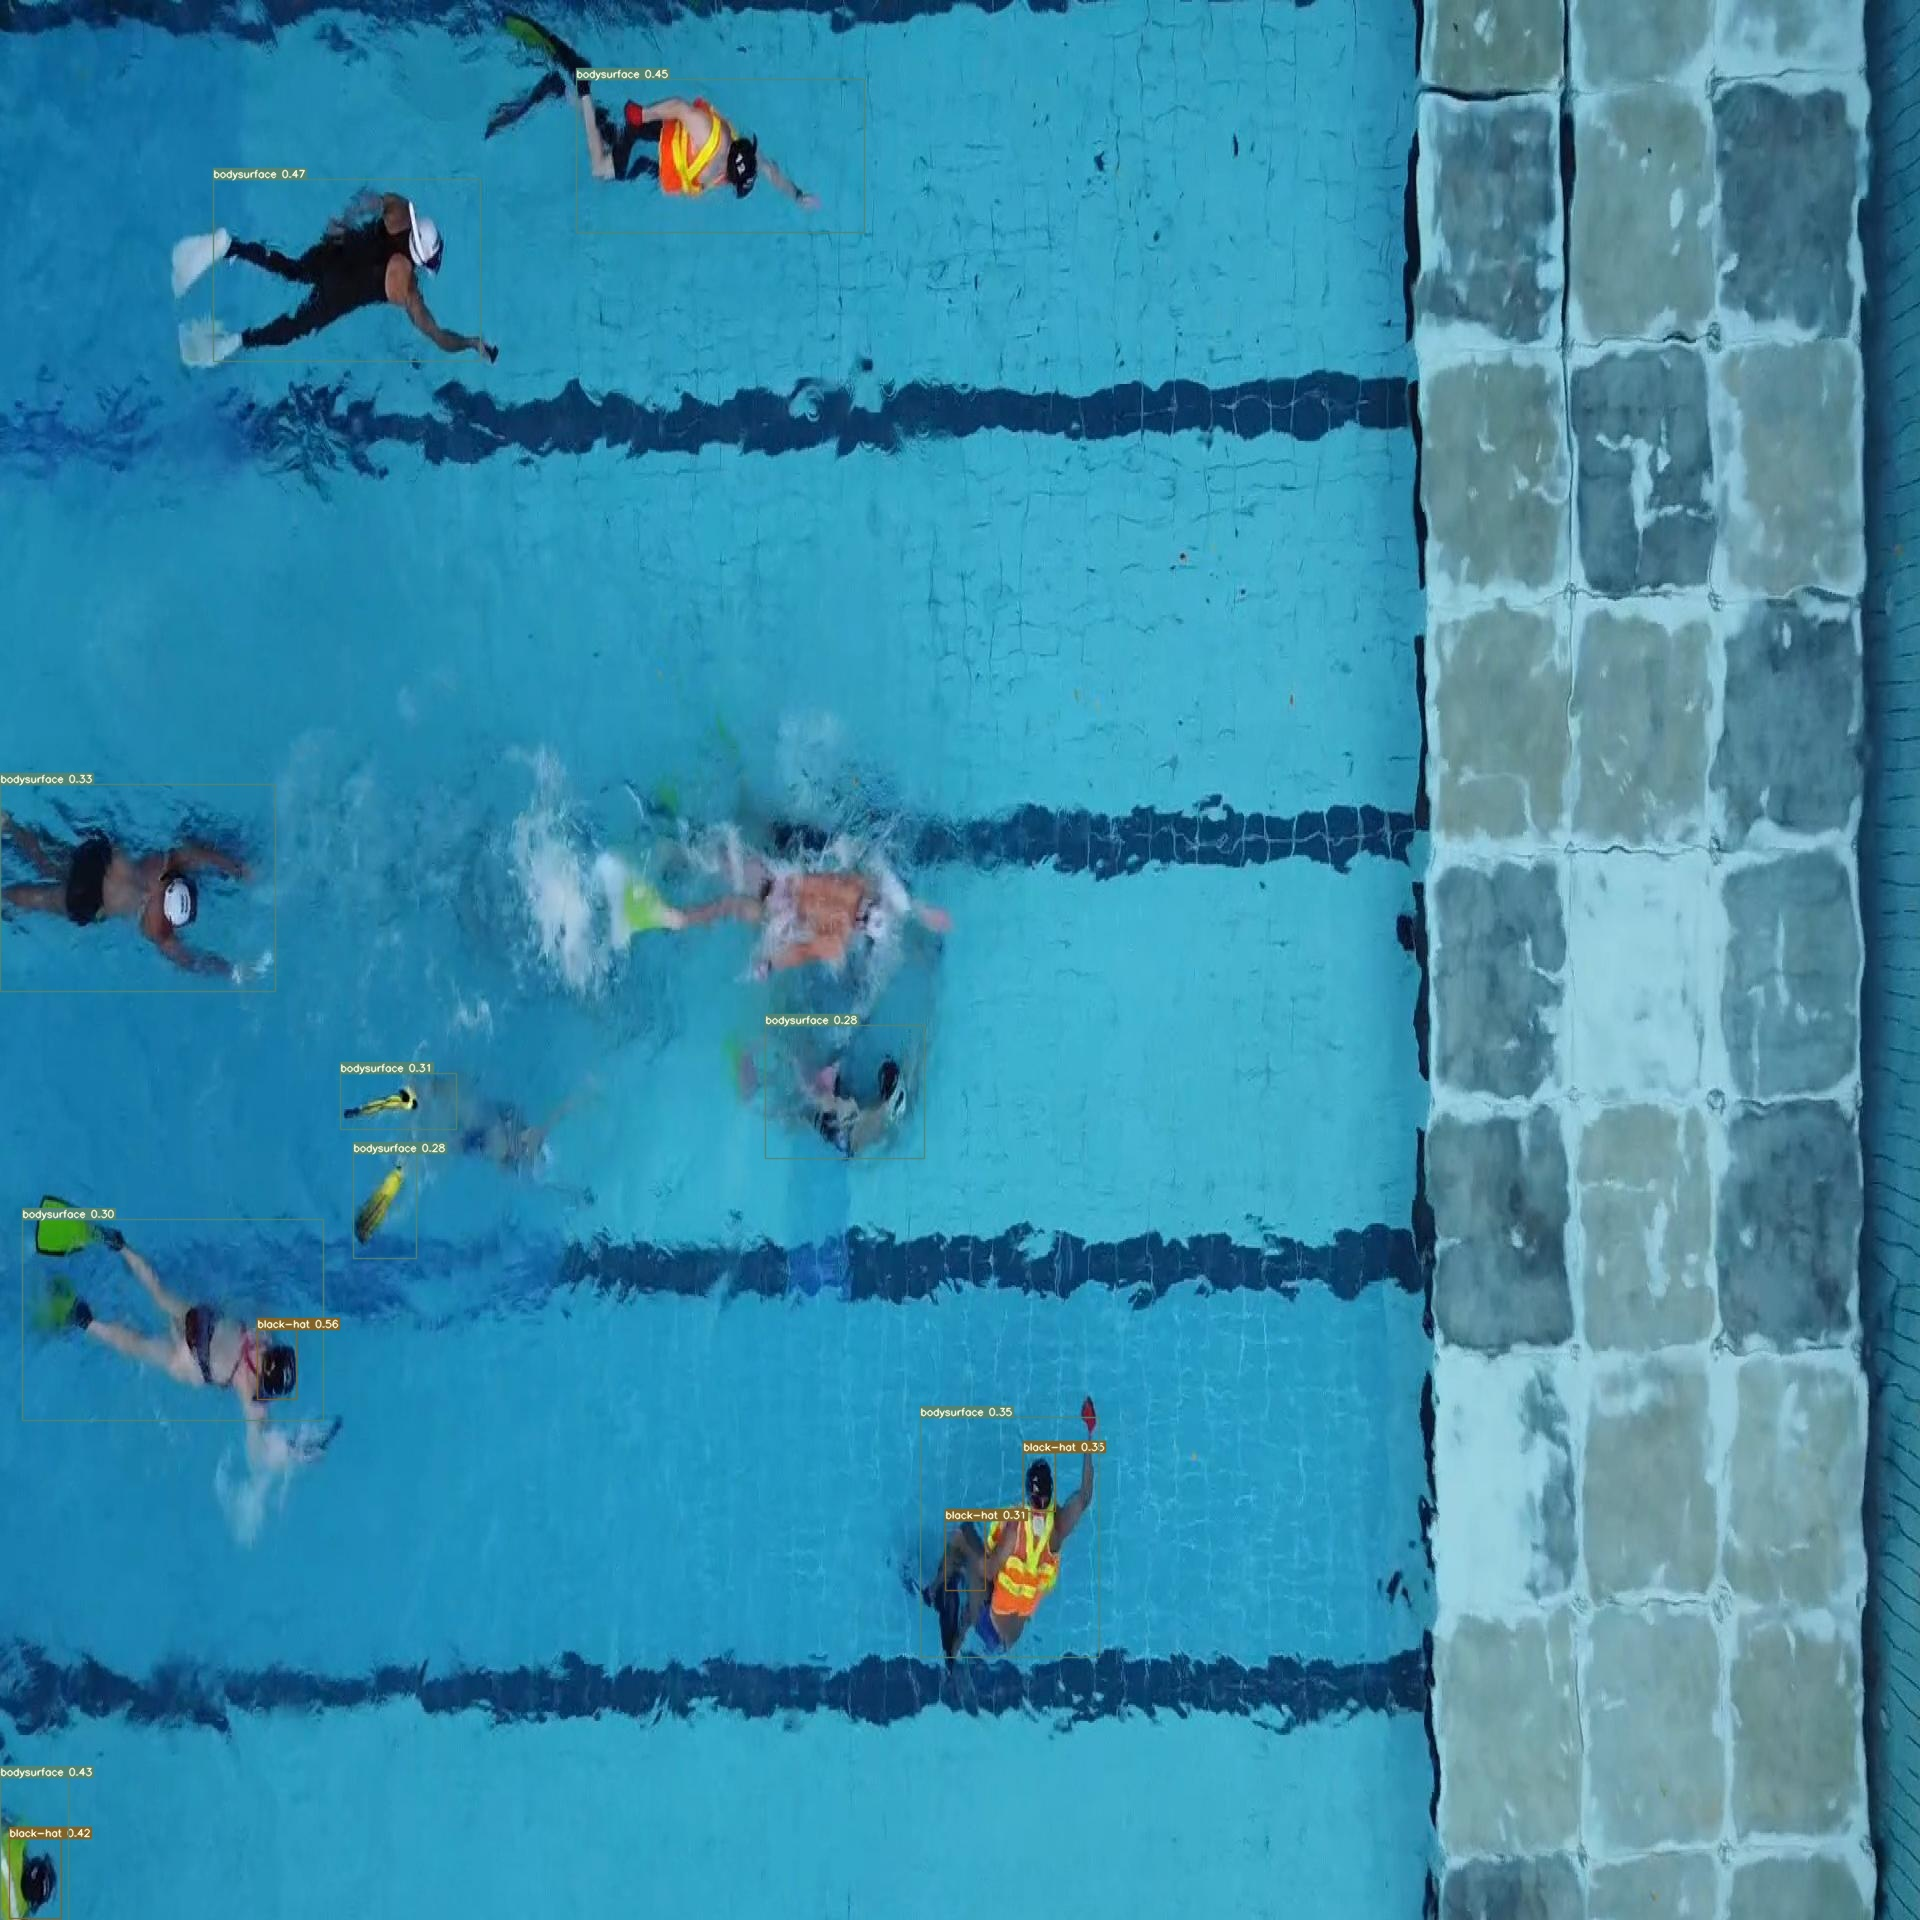

In [23]:
#display inference on a sample image

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
# Change the path below according to the location where result image is saved.
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #assuming JPG.
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1

# Evaluate YOLOv7 performance with OpenVINO™ integration with Torch-ORT

In [25]:
# Install torch-ort-infer
!pip install torch-ort-infer

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

Here, we added just 2 lines of code to boost performance with OpenVINO™ Torch-ORT

  line 17: from torch_ort import ORTInferenceModule

  line 71: model = ORTModule(model)   

In [27]:
# If you DO NOT have a retrained model, use this command to run evaluation using the provided trained model:
!python detect_ort.py --weights /content/yolov7/runs/best.pt --conf 0.25 --img-size 640 --source UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg

Traceback (most recent call last):
  File "/content/yolov7/detect_ort.py", line 17, in <module>
    from torch_ort import ORTInferenceModule
  File "/usr/local/lib/python3.11/dist-packages/torch_ort/__init__.py", line 6, in <module>
    from onnxruntime.training.ortmodule import DebugOptions, LogLevel
ModuleNotFoundError: No module named 'onnxruntime.training'


In [33]:
# Run evaluation on a sample image with a retrained model

!python detect_ort.py --weights /content/gdrive/MyDrive/TrainedModel/best.pt --conf 0.25 --img-size 640 --source UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg

Traceback (most recent call last):
  File "/content/yolov7/detect_ort.py", line 17, in <module>
    from torch_ort import ORTInferenceModule
  File "/usr/local/lib/python3.11/dist-packages/torch_ort/__init__.py", line 6, in <module>
    from onnxruntime.training.ortmodule import DebugOptions, LogLevel
ModuleNotFoundError: No module named 'onnxruntime.training'


# Display inference on test image

In [36]:
#display inference on sample image

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp2/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1

# Performance Boost with OpenVINO™ integration with TORCH-ORT

You may calculate the performance boost with OpenVINO™ integration with TORCH-ORT as compared to Native Pytorch using the formula:
<br>
</br>

PERFORMANCE BOOST (%) =
(inference time with native pytorch - inference time with T-ORT / inference time with native pytorch) * 100


# Next steps

Congratulations, you've ran inference on the YOLOv7 model!
<br>
 Next, start thinking about deploying and [building an MLOps pipeline](https://docs.roboflow.com) so your model gets better the more data it sees in the wild.